In [1]:
using PyPlot
using Random
using Statistics
import JSON: parsefile
import StatsBase
using Printf

In [2]:
## Some functions to replicate smithing
plt.style.use("seaborn-dark-palette")
bins = collect(1:1:8)
function dosmith(inferno)
    procs = 1
    while rand() < inferno
        procs += 1
    end
    return procs
end

function smithGold(count, inferno, timer)
    totalTime = 0
    while count > 0
        totalTime += timer
        count -= dosmith(inferno)
    end
    return totalTime
end

function smithSims(inferno)
    return [dosmith(inferno) for a in collect(1:10_000_000)]
end

function smithChi2(data, hypothesis)
    ## Data
    z = StatsBase.fit( StatsBase.Histogram, data, bins)
    zx, zy = (z.edges[1][2:end] + z.edges[1][1:end-1])/2.0 .- 0.5, z.weights
    #zy = zy ./ sum(zy)
    ## Function
    f = smithSims(hypothesis)
    h = StatsBase.fit( StatsBase.Histogram, f, bins)
    hx, hy = (h.edges[1][2:end] + h.edges[1][1:end-1])/2.0 .- 0.5, h.weights
    hy = hy ./ sum(hy) .* sum(zy)
    ## Chi2
    chi2 = (hy .- zy).^2 ./ hy ./ 2
    chi2[isnan.(chi2)] .= 0
    return sum( chi2 )
end

smithChi2 (generic function with 1 method)

In [3]:
## Collect the data
data = parsefile("output.json")["data"];
datacluster = []
timecluster = []
last = 0
count = 1
for d in data
    if (d - last) < 1000 ## Clustering
        count += 1
    else
        push!(datacluster, count)
        push!(timecluster, d)
        count = 1
    end
    last = d
end
datacluster = datacluster[2:end]
timecluster = timecluster[2:end]
h = StatsBase.fit( StatsBase.Histogram, datacluster, bins )
hx, hy = (h.edges[1][2:end] + h.edges[1][1:end-1])/2.0.-0.5, h.weights

([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0], [1480, 537, 184, 73, 29, 3, 4])

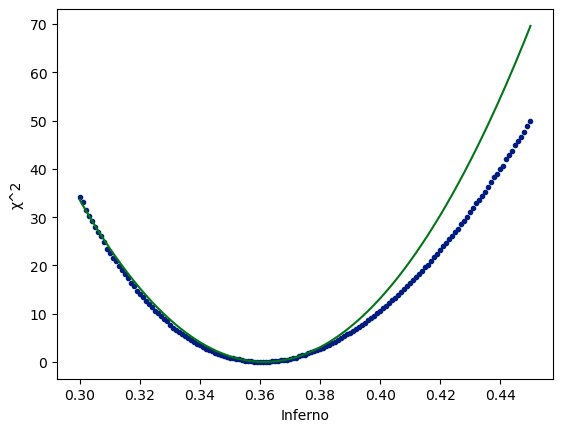

PyObject Text(24.000000000000007, 0.5, 'χ^2')

In [4]:
## Best fit for inferno proc
cx = collect(0.30:0.001:0.45)
cy = [smithChi2(datacluster, a) for a in cx]
cy = cy .- minimum(cy)
best_cx = cx[(cy .== minimum(cy))][1]
bandsX = cx[cy .< 0.5]
lb = minimum(bandsX)
rb = maximum(bandsX)
σ = (rb - lb)/2
μ = lb + σ
fform = ((cx.-μ).^2 ./2 ./σ^2)
plt.plot(cx, cy, ".")
plt.plot(cx, fform)
plt.xlabel("Inferno")
plt.ylabel("χ^2")

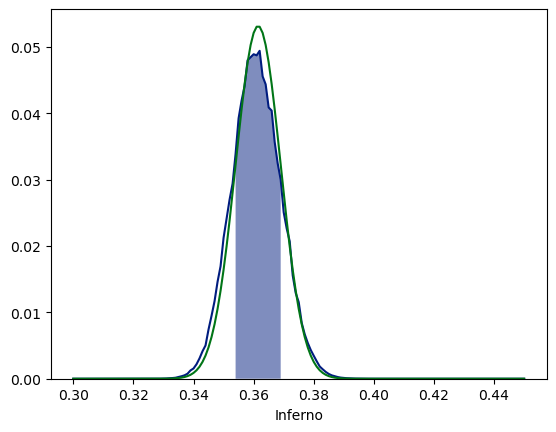

reject_forty = abs(0.4 - μ) / σ = 5.133333333333334
reject_thirty = abs(0.3 - μ) / σ = 8.199999999999992


sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


8.199999999999992

In [5]:
lratio = exp.(-cy)
lratio = lratio ./ sum(lratio)
bandsY = lratio[cy .< 0.5]
fform = exp.(-(cx.-μ).^2 ./2 ./σ^2)
plt.plot(cx, lratio)
plt.plot(cx, fform ./sum(fform))
plt.fill_between(bandsX, 0, bandsY, alpha=0.5)
plt.ylim(bottom=0)
plt.xlabel("Inferno")
plt.show()

@show reject_forty = abs(0.4 - μ)/σ
@show reject_thirty = abs(0.3 - μ)/σ 

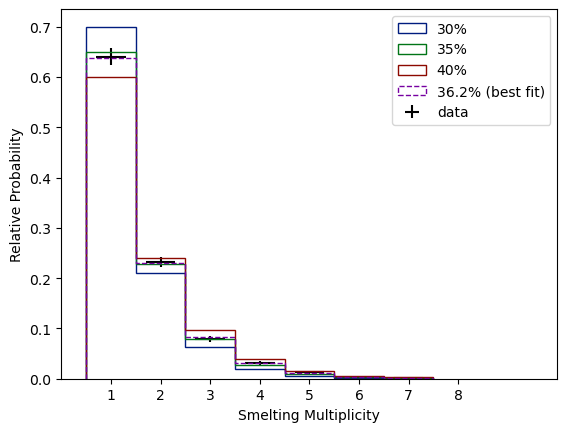

PyObject <matplotlib.legend.Legend object at 0x7fac615478e0>

In [6]:
## Plot inferno proc multiplicity (with best fit)
fsix = smithSims(0.3)
fseven = smithSims(0.35)
feight = smithSims(0.40)
fBest = smithSims(best_cx)
bestLabel = @sprintf("%0.1f%% (best fit)",best_cx*100)
plt.hist(fsix,   bins=bins, histtype="step", label="30%", density=true, align="left")
plt.hist(fseven, bins=bins, histtype="step", label="35%", density=true, align="left")
plt.hist(feight, bins=bins, histtype="step", label="40%", density=true, align="left")
plt.hist(fBest, bins=bins, histtype="step", label=bestLabel, density=true, align="left", linestyle="dashed" )
#plt.hist(datacluster, bins=bins, histtype="step", label="data", density=true, align="left")
plt.errorbar(hx, hy/sum(hy), yerr=sqrt.(hy)/sum(hy), xerr=0.3, ls="none", label="data", color="black")
plt.xlim(0,10)
plt.xlabel("Smelting Multiplicity")
plt.ylabel("Relative Probability")
plt.xticks(bins)
#plt.yscale("log")
plt.legend()

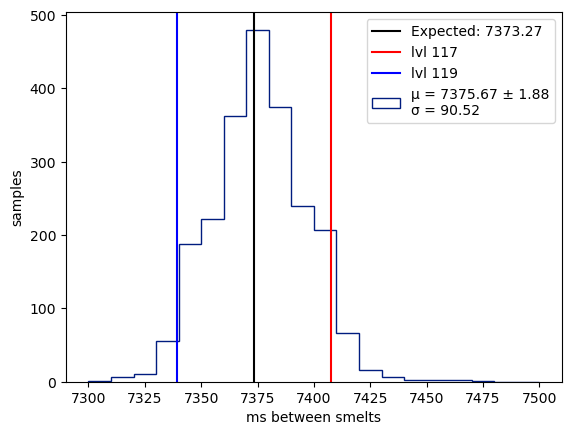

PyObject <matplotlib.legend.Legend object at 0x7fac615117f0>

In [7]:
## time between procs
## What should it be? Data was taken on gold ore, with effective level 118 w/ haste 5
expTime(lvl) = (20.0)/(99+lvl)*100*0.8*1000
expectedTime = expTime(118)
timeDelta = (timecluster - circshift(timecluster, 1))[2:end]
#cleanTD = timeDelta[(datacluster[2:end] .== 1)]
dtbins = collect(7300:10:7500)
mn  = mean(timeDelta)
dev = std(timeDelta)
mn_unc = dev / sqrt(length(timeDelta)-1)
label = @sprintf("μ = %0.2f ± %0.2f\nσ = %0.2f", mn, mn_unc, dev)
plt.hist(timeDelta, bins=dtbins, histtype="step", label=label)
vlabel = @sprintf("Expected: %0.2f", expectedTime)
plt.axvline(expectedTime, color="black", label=vlabel)
plt.axvline(expTime(117), color="red", label="lvl 117")
plt.axvline(expTime(119), color="blue", label="lvl 119")
#plt.hist(cleanTD, bins=dtbins, histtype="step", density=true)
plt.xlabel("ms between smelts")
plt.ylabel("samples")
plt.legend()

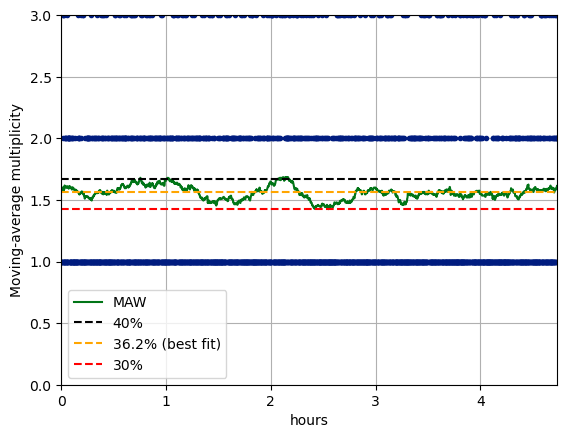

PyObject <matplotlib.legend.Legend object at 0x7fac306b5c40>

In [8]:
# Time series variation?
function maw(x, size)
    backwards = div(size, 2)
    forwards = isodd(size) ? div(size, 2) : div(size, 2) - 1
    len = length(x)
    y = similar(x)
    for n = 1:len
        lo = max(1, n - backwards)
        hi = min(len, n + forwards)
        y[n] = mean(x[lo:hi])
    end
    y
end
tc = ((timecluster.-timecluster[1])/3600000)
plt.plot(tc, maw(datacluster, 1), ".")
plt.plot(tc, maw(datacluster, 200), label="MAW")
plt.axhline(mean(feight), color="black", linestyle="dashed", label="40%")
plt.axhline(mean(fBest), color="orange", linestyle="dashed", label=bestLabel)
plt.axhline(mean(fsix), color="red", linestyle="dashed", label="30%")
plt.xlabel("hours")
plt.ylabel("Moving-average multiplicity")
plt.xlim(minimum(tc), maximum(tc))
plt.ylim(0, 3)
plt.xticks(collect(0:1.0:maximum(tc)))
plt.grid()
plt.legend()